PART 1 : Entertainment - Face detection from Training Images

Import the dataset

In [2]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.8.0'

In [3]:
import os
import numpy as np
import pandas as pd
import cv2
from glob import glob

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray

In [4]:
import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")

In [20]:
cd "/content/drive/MyDrive/Computervision"


/content/drive/MyDrive/Computervision


In [21]:
data = np.load('images.npy', allow_pickle=True)


In [22]:
data.shape

(409, 2)

In [23]:
data[0][0]


array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [24]:
data[408][1]


[{'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3201219512195122, 'y': 0.2839756592292089},
   {'x': 0.4009146341463415, 'y': 0.4198782961460446}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4557926829268293, 'y': 0.38742393509127787},
   {'x': 0.5442073170731707, 'y': 0.5618661257606491}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6707317073170732, 'y': 0.38336713995943206},
   {'x': 0.7134146341463414, 'y': 0.4746450304259635}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.16615853658536586, 'y': 0.4665314401622718},
   {'x': 0.22560975609756098, 'y': 0.563894523326572}]},
 {'imageHeight': 493,
  'imageWidth': 656,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.07164634146341463, 'y': 0.539553752535497},
   {'x': 0.11280487804878049, 'y': 0.586206896551

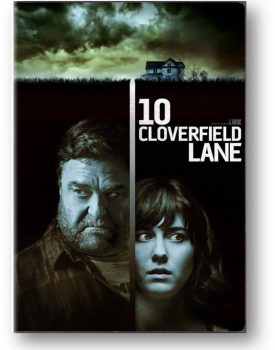

In [25]:
from google.colab.patches import cv2_imshow

cv2_imshow(data[23][0])

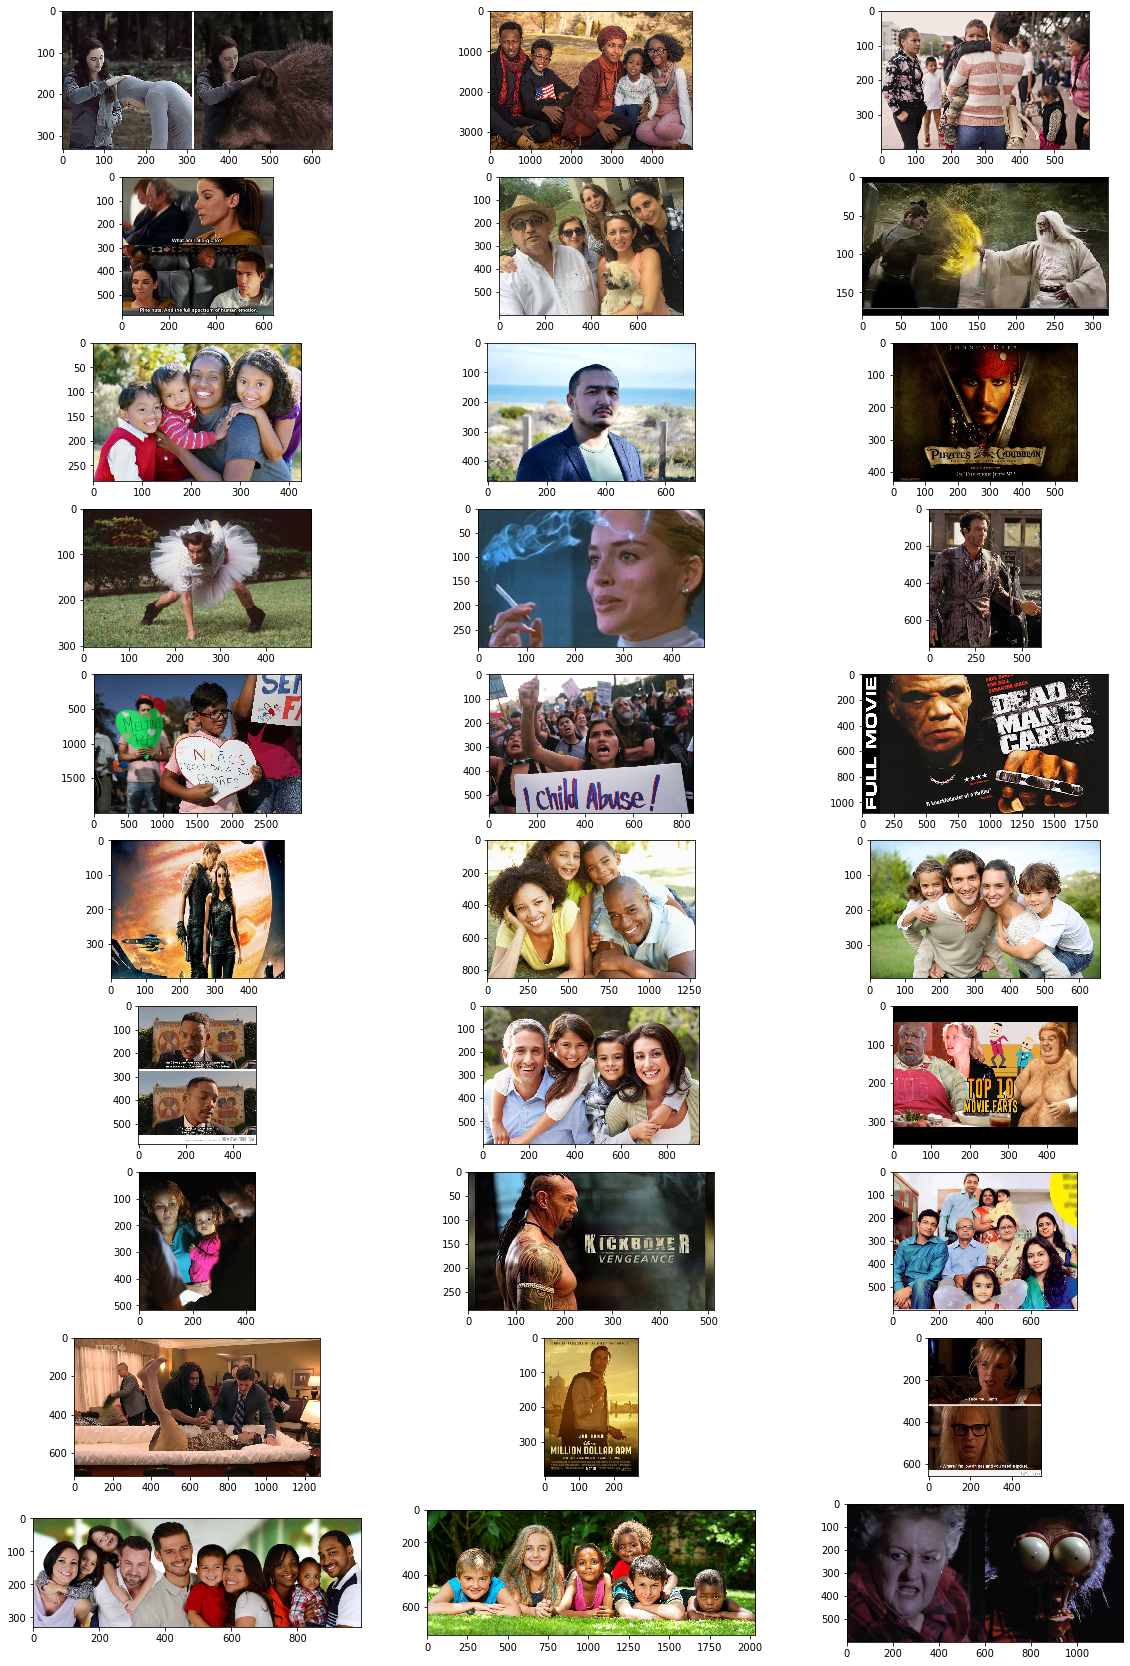

In [26]:
fi,ax = plt.subplots(10,3,figsize=(20,30))
row = 0
col = 0
index = 0
for i in range(30):
  ax[row][col].imshow(data[index][0], interpolation='nearest')
  index = index + 12
  col = col + 1
  if col > 2:
    row = row + 1
    col = 0
plt.show()

Create features (images) and labels (mask) using that data

In [27]:
from tensorflow.keras.applications.mobilenet import preprocess_input

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]),IMAGE_HEIGHT, IMAGE_WIDTH, 3))

for index in range(data.shape[0]):
  img = data[index][0]
  img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
 
  try:
    img = img[:,:,:3]
  except:
    print(f"Exception {index} Grayscale image with shape {img.shape}")
   
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    continue
  X[index] = preprocess_input(np.array(img, dtype=np.float32))
  for i in data[index][1]:
    x1 = int(i['points'][0]['x'] * IMAGE_WIDTH)
    x2 = int(i['points'][1]['x'] * IMAGE_WIDTH)
    y1 = int(i['points'][0]['y'] * IMAGE_HEIGHT)
    y2 = int(i['points'][1]['y'] * IMAGE_HEIGHT)
    masks[index][y1:y2, x1:x2] = 1
print(f"### Shape of X is '{X.shape}' and the shape of mask is '{masks.shape}' ")

Exception 272 Grayscale image with shape (224, 224)
### Shape of X is '(409, 224, 224, 3)' and the shape of mask is '(409, 224, 224)' 


In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, masks, test_size=0.2)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.2)

print(f"Shape of X_train is '{X_train.shape}' and the shape of y_train is '{y_train.shape}'")
print(f"Shape of X_val is '{X_val.shape}' and the shape of y_val is '{y_val.shape}'")
print(f"Shape of X_test is '{X_test.shape}' and the shape of y_test is '{y_test.shape}'")

Shape of X_train is '(327, 224, 224, 3)' and the shape of y_train is '(327, 224, 224)'
Shape of X_val is '(65, 224, 224, 3)' and the shape of y_val is '(65, 224, 224)'
Shape of X_test is '(17, 224, 224, 3)' and the shape of y_test is '(17, 224, 224)'


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


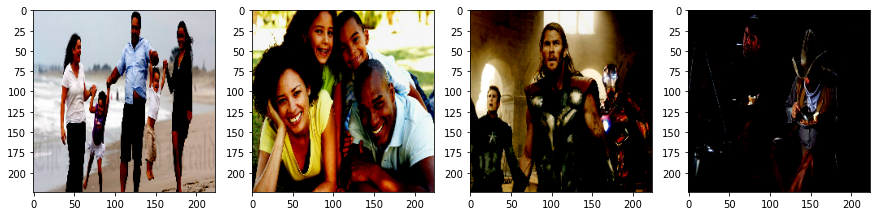

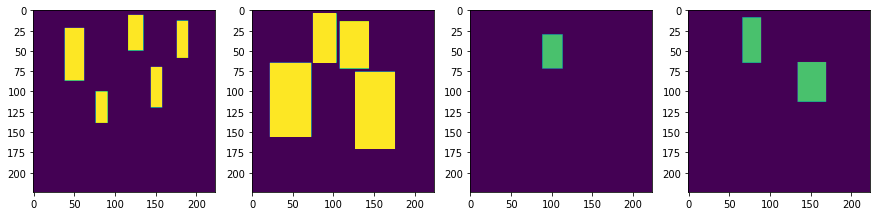

In [29]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(X_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(X_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(X_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(X_train[30])
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(y_train[0])

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(y_train[10])
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(y_train[20])
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(y_train[30])
imgplot.set_clim(0.0, 1.4)

In [30]:
IMAGE_SIZE = 224
EPOCHS = 30
BATCH = 8
LR = 1e-4

Mask detection model

In [31]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [32]:
model = model()
model.summary()

2031616/2019640 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_image (InputLayer)       [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 16  432         ['input_image[0][0]']            
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 16  64          ['Conv1[0][0]']                  
                               

In [36]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [38]:
import tensorflow as tf

opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [39]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [40]:
train_steps = len(X_train)//BATCH
valid_steps = len(X_val)//BATCH

if len(X_train) % BATCH != 0:
    train_steps += 1
if len(X_val) % BATCH != 0:
    valid_steps += 1

model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/30
41/41 [==============================] - 102s 2s/step - loss: 0.7272 - dice_coef: 0.2729 - recall: 0.5482 - precision: 0.3075 - val_loss: 0.7004 - val_dice_coef: 0.2818 - val_recall: 0.9971 - val_precision: 0.1630 - lr: 1.0000e-04
Epoch 2/30
41/41 [==============================] - 88s 2s/step - loss: 0.5996 - dice_coef: 0.4007 - recall: 0.8582 - precision: 0.4352 - val_loss: 0.6810 - val_dice_coef: 0.3003 - val_recall: 0.9918 - val_precision: 0.1970 - lr: 1.0000e-04
Epoch 3/30
41/41 [==============================] - 93s 2s/step - loss: 0.5559 - dice_coef: 0.4443 - recall: 0.8874 - precision: 0.4690 - val_loss: 0.6266 - val_dice_coef: 0.3532 - val_recall: 0.9670 - val_precision: 0.2843 - lr: 1.0000e-04
Epoch 4/30
41/41 [==============================] - 88s 2s/step - loss: 0.5328 - dice_coef: 0.4672 - recall: 0.8866 - precision: 0.4976 - val_loss: 0.5954 - val_dice_coef: 0.3836 - val_recall: 0.9515 - val_precision: 0.3427 - lr: 1.0000e-04
Epoch 5/30
41/41 [=================

In [41]:
test_steps = (len(X_test)//BATCH)
if len(X_test) % BATCH != 0:
    test_steps += 1

model.evaluate(X_test, y_test, steps=test_steps)

3/3 [==============================] - 1s 359ms/step - loss: 0.4526 - dice_coef: 0.5496 - recall: 0.6901 - precision: 0.6318


[0.4526396691799164,
 0.5496283173561096,
 0.6901187300682068,
 0.6317844986915588]

Use the “Prediction image” as an input to your designed model and display the output of the image

In [42]:
filename = './Part+1Test+Data+-+Prediction+Image.jpeg'
unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [43]:
feat_scaled

array([[[ 0.5686275 ,  0.4666667 ,  0.45098042],
        [ 0.56078434,  0.45882356,  0.4431373 ],
        [ 0.5764706 ,  0.47450984,  0.45882356],
        ...,
        [-0.17647058, -0.5058824 , -0.73333335],
        [-0.27058822, -0.49019605, -0.75686276],
        [-0.27843136, -0.47450978, -0.7411765 ]],

       [[ 0.6       ,  0.49803925,  0.48235297],
        [ 0.6       ,  0.4901961 ,  0.48235297],
        [ 0.6313726 ,  0.5294118 ,  0.5137255 ],
        ...,
        [-0.20784312, -0.52156866, -0.7490196 ],
        [-0.16862744, -0.40392154, -0.6627451 ],
        [-0.19215685, -0.41176468, -0.6784314 ]],

       [[ 0.54509807,  0.45098042,  0.41960788],
        [ 0.47450984,  0.3803922 ,  0.34901965],
        [ 0.5372549 ,  0.4431373 ,  0.4039216 ],
        ...,
        [-0.14509803, -0.42745095, -0.6627451 ],
        [-0.3098039 , -0.5686275 , -0.827451  ],
        [-0.34117645, -0.5921569 , -0.8509804 ]],

       ...,

       [[-1.        , -1.        , -1.        ],
        [-1

In [44]:
y_pred = model.predict(np.array([feat_scaled]))
y_pred

array([[[[0.06014705],
         [0.05434242],
         [0.0619373 ],
         ...,
         [0.04696602],
         [0.04806182],
         [0.0431847 ]],

        [[0.05291471],
         [0.05561176],
         [0.04442203],
         ...,
         [0.03623393],
         [0.03268328],
         [0.04316801]],

        [[0.05082169],
         [0.063014  ],
         [0.04948464],
         ...,
         [0.05681393],
         [0.03718421],
         [0.04632992]],

        ...,

        [[0.10260248],
         [0.07120675],
         [0.06030259],
         ...,
         [0.0455704 ],
         [0.042909  ],
         [0.05203295]],

        [[0.12099743],
         [0.06859499],
         [0.05911025],
         ...,
         [0.05201033],
         [0.05413535],
         [0.06684139]],

        [[0.0889098 ],
         [0.09093142],
         [0.06472853],
         ...,
         [0.05698428],
         [0.080116  ],
         [0.07672024]]]], dtype=float32)

In [45]:
pred_mask = cv2.resize((1.0*(y_pred[0] > 0.5)), (IMAGE_WIDTH,IMAGE_HEIGHT))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


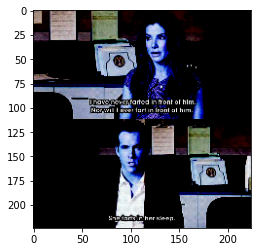

In [46]:
plt.imshow(feat_scaled)

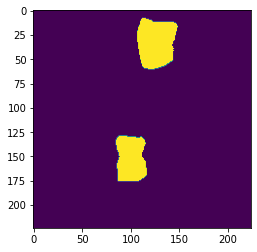

In [47]:
plt.imshow(pred_mask)